In [2]:
import os
import torch
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, Tuple, Optional, List

In [3]:
os.chdir('..')  # change working directory to root

In [4]:
from agents.td3 import TD3
from agents.d3qn import D3QN
from mdp.mimic_iii.reward_functions.abstract_reward_function import AbstractRewardFunction
from mdp.mimic_iii.reward_functions.factory import Factory as RewardFnFactory
from mdp.mimic_iii.reward_functions.peng_reward_function import PengRewardFunction
from mdp.mimic_iii.action_spaces.discrete import Discrete as DiscreteActionSpace
from mdp.mimic_iii.state_spaces.sparse_autoencoder import SparseAutoEncoder as MimicIIISparseAutoEncoderStateSpace
from ope.behavior_policies.kmeans_sarsa import KMeansSarsa
from utilities import mimic_iii_funcs
from utilities.device_manager import DeviceManager

In [5]:
# reward function details dict
reward_fn_details_dict = {
    'sparse': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/vm/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '97629e709d7f45ec851200c6b0d497df',
        'd3qn_run_id': '5944007810ef4e318106533adbd6ccb6',
        'd3qn_magic_run_id': '85de6b80c8374e489bb49164bcbf29a5',
        'ddpg_run_id': 'cba965ed952945a1a0d9660d807cf2a0',
        'ddpg_magic_run_id': 'f835cde18011478693931ecc0247df63',
    },
    'wu': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '6dd75e96646b45938f225f3964705324',
        'd3qn_run_id': '5d140bdb06e344bd888876561f010f0e',
        'd3qn_magic_run_id': 'fd3f75118286426f88ca127246e33cda',
        'ddpg_run_id': '67c02a6bab0b4d74aadf585f7c8edd87',
        'ddpg_magic_run_id': '18ed010dada041f79639230d54ca5db7',
    },
    'yong': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': 'ecac4334f1994260b2bcd420b671c53a',
        'd3qn_run_id': '8f098fb13a5b41da9e77dac2ae13d321',
        'd3qn_magic_run_id': '29ad84ac64ed4ab98f7e10488887f301',
        'ddpg_run_id': '30cccf0e3c2c4ffaa1a9ea1c2bf23972',
        'ddpg_magic_run_id': '7ecad48fb0e04388b048d183b195e5f8',
    },
    'raghu': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '17d5de3272cb4e2892e6e438d22c2af4',
        'd3qn_run_id': '9a5d00e3454840499ce4697fa6bf472c',
        'd3qn_magic_run_id': 'd2584eef61284bc4bc9d57402927b750',
        'ddpg_run_id': 'da45045dfb1042d1a21a06360ca55239',
        'ddpg_magic_run_id': '01c5faa0f8ee4a5b9cb08a712060dc0e',
    },
    'peng': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '1e6330b7604f4aad8da905239c1b5070',
        'd3qn_run_id': '37d3ea87328d4c94a75c5d6e0011495a',
        'd3qn_magic_run_id': '68161afeb1ff41bbbc795f91e6a42c5b',
        'ddpg_run_id': 'b008b48ce39d4847ae2d377b4cbb91ba',
        'ddpg_magic_run_id': '2d6c08b95c8e40c2a6a0473a3b12f737',
        'reward_fn_run_id': '211c5a3c31f147f38d63b6b357a7b610',
    },
}

In [6]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data: torch.FloatTensor, lbls: torch.LongTensor):
        super().__init__()
        self._data = data
        self._lbls = lbls
        
    def __len__(self) -> int:
        return self._data.size(0)

    def __getitem__(self, item: int) -> Tuple[torch.FloatTensor, torch.LongTensor]:
        return self._data[item], self._lbls[item]

def load_split_peng_train_val_data(split_: int, batch_size: int = 512) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    # load and preprocess mimic data
    discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(split_)
    discrete_mimic_df, discrete_min_max_scaler, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'peng_reward_fn')
    # discrete split
    (
        (train_survived_data, train_survived_lbls, train_died_data, train_died_lbls),
        (val_survived_data, val_survived_lbls, val_died_data, val_died_lbls),
        (test_survived_data, test_survived_lbls, test_died_data, test_died_lbls)
    ) = mimic_iii_funcs.train_val_test_split_mimic_data(discrete_mimic_df, 'peng_reward_fn')
    # stack data
    train_data, train_lbls = torch.vstack((train_survived_data, train_died_data)), torch.concat((train_survived_lbls, train_died_lbls), dim=0)
    val_data, val_lbls = torch.vstack((val_survived_data, val_died_data)), torch.concat((val_survived_lbls, val_died_lbls), dim=0)
    # test_data, test_lbls = torch.vstack((test_survived_data, test_died_data)), torch.concat((test_survived_lbls, test_died_lbls), dim=0)
    # create discrete dataloaders
    train_dataset = SimpleDataset(train_data, train_lbls)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = SimpleDataset(val_data, val_lbls)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader

def load_reward_fn(reward_fn_results_dict_: Dict[str, str], split_: int) -> AbstractRewardFunction:
    reward_fn_ = RewardFnFactory.create('peng')
    peng_run_id = reward_fn_results_dict_['reward_fn_run_id']
    reward_fn_.load(f'runs:/{peng_run_id}/split_{split_}')
    return reward_fn_

def eval_peng_reward_fn(reward_fn: PengRewardFunction, dataloader: torch.utils.data.DataLoader) -> float:
    reward_fn.eval()
    acc, num_samps = 0.0, 0
    for data, lbls in dataloader:
        with torch.no_grad():
            preds = reward_fn.predict(data)
            preds = torch.where(preds > 0.5, 1, 0)
            batch_acc = (preds == lbls).sum().cpu().item()
            acc += batch_acc
            num_samps += lbls.size(0)
    acc /= num_samps # mean acc
    return acc

def compute_peng_stats(reward_fn_details_dict_: Dict[str, Dict[str, str]], splits: List[int] = list(range(10))) -> pd.DataFrame:
    results = pd.DataFrame(columns=['acc', 'dataset', 'split'])
    reward_fn_results_dict = reward_fn_details_dict_['peng']
    mlflow_path = reward_fn_results_dict['mlflow_base_path']
    mlflow.set_tracking_uri(mlflow_path)
    for split in splits:
        reward_fn = load_reward_fn(reward_fn_results_dict, split)
        train_dataloader, val_dataloader = load_split_peng_train_val_data(split)
        mean_train_acc = eval_peng_reward_fn(reward_fn, train_dataloader)
        mean_val_acc = eval_peng_reward_fn(reward_fn, val_dataloader)
        results.loc[results.shape[0]] = [mean_train_acc, 'train', split]
        results.loc[results.shape[0]] = [mean_val_acc, 'val', split]
    results['split'] = results['split'].astype(int)
    return results
    
def do_peng_stats_plots(results: pd.DataFrame):
    ax = sns.boxplot(results, x='dataset', y='acc')
    plt.show()

def extract_peng_stats(results: pd.DataFrame) -> Tuple[float, float, float, float]:
    train_view = results.loc[results.dataset == 'train', 'acc']
    train_acc_mean = train_view.mean().item()
    train_acc_std = train_view.std().item()
    val_view = results.loc[results.dataset == 'val', 'acc']
    val_acc_mean = val_view.mean().item()
    val_acc_std = val_view.std().item()
    return train_acc_mean, train_acc_std, val_acc_mean, val_acc_std

2024/09/16 14:03:54 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/09/16 14:03:57 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/09/16 14:04:00 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/09/16 14:04:02 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/09/16 14:04:05 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/09/16 14:04:08 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/09/16 14:04:10 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/09/16 14:04:13 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

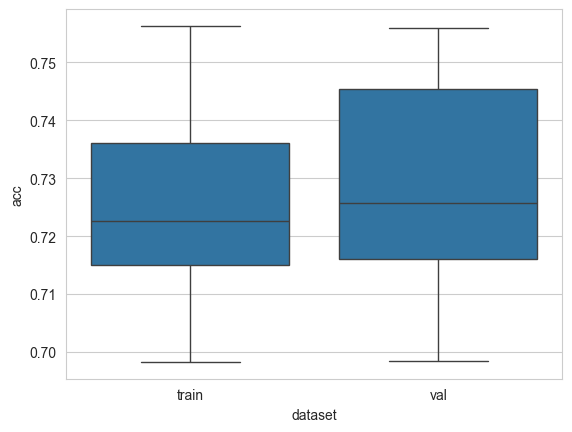

In [7]:
results_df = compute_peng_stats(reward_fn_details_dict)
do_peng_stats_plots(results_df)

In [8]:
train_mean_acc, train_std_acc, val_mean_acc, val_std_acc = extract_peng_stats(results_df)
print(f'Train Accuracy: {train_mean_acc:.4f} +/- {train_std_acc:.4f}')
print(f'Validation Accuracy: {val_mean_acc:.4f} +/- {val_std_acc:.4f}')

Train Accuracy: 0.7262 +/- 0.0195
Validation Accuracy: 0.7284 +/- 0.0188
